In [1]:
import IPython

# Medición de la periodicidad utilizando RVS y la transformada de Fourier

In [221]:
#Carga las librerías requeridas
from scipy.fftpack import fft, fftfreq, fftshift
from SERGIO import event2bin, FRcausalR
from Phd import vecstrength, RVStr, synchronization
import matplotlib.pyplot as plt
import numpy as np
from Phd_ext import FRcausalR as FRcausalRcython

#Carga los archivos de prueba para utilizarse con el vector strength
periodico=np.loadtxt('Periodico_f_20_N_200.txt', dtype=float, delimiter=',')
perperf=np.copy(periodico[0:50][::])
pernoise=np.copy(periodico[50::][::])
Nper=np.loadtxt('NonPeriodico_f_20_N_200.txt', dtype=float, delimiter=',')
del periodico

La fase a continuación generará los vectores para generar los trenes de ceros y uno los archivos para utilizar la transformada de Fourier directamente (caso 1) y también utilizará los vectores de tiempos para generar un vector de tasa que permita generar una función a la cual se le calculará la transformada de Fourier. La frecuencia de muestreo utilizada será de 30khz. Cada segmento de archivo periódico contiene 50 ensayos.

## La frecuencia de los disparos en los archivos periódicos con y sin ruido es de 20 Hz

In [222]:
freq=2000 #frecuencia de muestreo es de 30khz
FFT1binperperf=np.zeros((50, 1), dtype=float)
FFT1binpernoise=np.zeros((50, 1), dtype=float)
FFT1binNper=np.zeros((50, 1), dtype=float)
# Los que siguen son los archivos para la segunda forma de calcular la periodicidad
FFT2binperperf=np.zeros((50, 1), dtype=float)
FFT2binpernoise=np.zeros((50, 1), dtype=float)
FFT2binNper=np.zeros((50, 1), dtype=float)


Ahora, el siguiente bloque nos permitirá obtener los valores de periodicidad para los tres métodos.

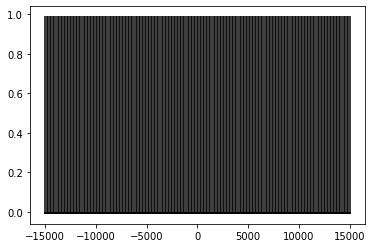

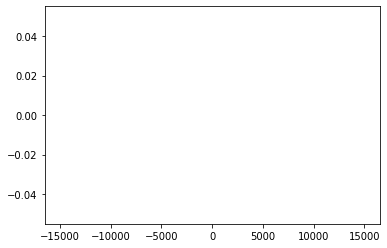

In [223]:
index=0
binperperf=event2bin(perperf[index, :], freq)
binpernoise=event2bin(pernoise[index, :], freq)
binNper=event2bin(Nper[index, :], freq)
#La siguiente sección generará los archivos de tasa con una ventana de 30 ms
# con el fin de realizar una transformada de Fourier.
Gperperf=FRcausalRcython(perperf[index, :], 0.050 ,freq)
Gpernoise=FRcausalRcython(pernoise[index, :], 0.030,freq)
GNper=FRcausalRcython(Nper[index, :], 0.030 ,freq)
# La siguiente parte calcula la transoformada de Fourier
fbinperperf=fft(binperperf-np.mean(binperperf))
frq=fftfreq(len(binperperf), 1/30000)
plt.vlines(fftshift(frq), 0, fbinperperf.real)
plt.figure(2)
plt.vlines(frq, 0, fbinperperf.imag)

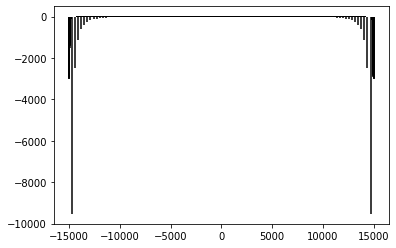

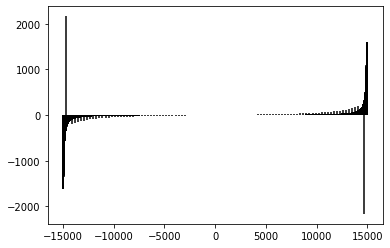

In [225]:
fGperperf=fft(Gperperf-np.mean(Gperperf)) #Susbstracts the mean
frq=fftfreq(len(Gperperf), 1/30000)
frq=fftshift(frq)  #Adjusts values to the correct frequencies
plt.figure(4)
plt.vlines(frq, 0, fGperperf.real)
plt.figure(3)
plt.vlines(frq, 0, fGperperf.imag)

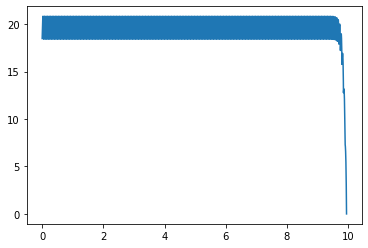

In [227]:
plt.plot(np.arange(0, (len(Gperperf))/freq, 1/freq) ,Gperperf)

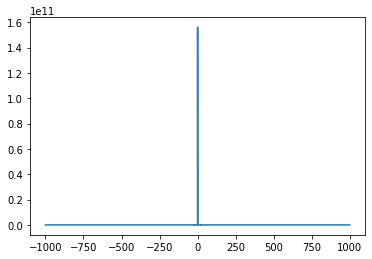

In [228]:
from __future__ import division

ps = np.abs(np.fft.fft(Gperperf))**2

time_step = 1 / freq
freqs = np.fft.fftfreq(Gperperf.size, time_step)
idx = np.argsort(freqs)

plt.plot(freqs[idx], ps[idx])

## Prueba con un archivo real del mono RR033


In [229]:
from pyexcel_ods import get_data
from Phd_ext import FRcausalR as FRcausalRcython
fs=2000
data=get_data("/run/media/sparra/AENHA/BaseDatosKarlitosNatsushiRR032/Text_s/RR032179_002/RR032179_002_e5_u1.csv", delimiter="\t")
data=data["RR032179_002_e5_u1.csv"]
A=np.loadtxt("/run/media/sparra/AENHA/BaseDatosKarlitosNatsushiRR032/Text_s/RR032179_002/RR032179_002_e5_u1.csv", usecols=(0), delimiter="\t")
A=A-1
Psyc=np.loadtxt("/run/media/sparra/AENHA/BaseDatosKarlitosNatsushiRR032/Text_s/RR032179_002/RR032179_002_Psyc.csv", delimiter=",")
Psyc=Psyc[A.astype(int), :]
T=np.loadtxt("/run/media/sparra/AENHA/BaseDatosKarlitosNatsushiRR032/Text_s/RR032179_002/RR032179_002_T.csv", delimiter=",")
T=T[A.astype(int), :]
mask24=np.where(Psyc[:, 11]==24)[0]
spikes=np.array(data[mask24[2]][1::] )                 #Tiempos en las coordenadas 6 y 7
spikesb=spikes[np.where((spikes>=( T[mask24[2], 6]-0.3 ))*(spikes<=( T[mask24[2], 7]+0.3) ))[0] ]
#%time tasa=FRcausalR(spikes-spikes[0], 0.012, fs)
#i2=int( (T[mask24[2], 7]+0.3)*2000)
#i1=int( (T[mask24[2], 6]-0.3)*2000)
%time tasa_cython=FRcausalRcython(spikesb, 0.010, fs)

CPU times: user 1.27 ms, sys: 24 µs, total: 1.3 ms
Wall time: 1.3 ms


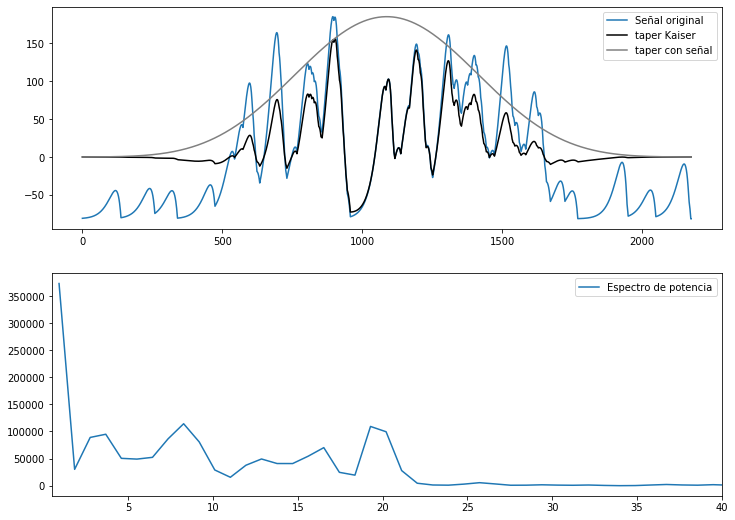

In [15]:
segmento=tasa_cython#[i1:i2]
figure, ax=plt.subplots(2, 1, figsize=(12, 9))
ax[0].plot(segmento, label="Señal original")
segmento-=np.mean(segmento)
taper=np.kaiser(len(segmento), 12)
ax[0].plot(segmento*taper, c="k", label="taper Kaiser")
ax[0].plot(taper*np.max(segmento), c="gray", label="taper con señal")
ax[0].legend()
y=fft(segmento*taper)
frq=fftfreq(len(segmento), 1/fs)
wh=np.where(frq>0)
#frq=fftshift(frq)  #Adjusts values to the correct frequencies
#ax[1].vlines(frq, abs(y.real), ymax=400000)
y=1/len(segmento)*(np.abs(y)**2)
ax[1].plot(frq[wh], y[wh], label="Espectro de potencia")
ax[1].set_xlim([0.5, 40])
ax[1].legend()


In [218]:
index=np.where( (frq>0)*(frq<36) )[0] 
index2=np.where((frq>=16.5)*(frq<=19) )[0] 
periodicity=(np.sum(y[index2]))/np.sum(y[index])
print(periodicity)

0.06862244236598912


In [101]:
from Phd_ext import vecstrength
spikesb=spikes[np.where((spikes>=( T[mask24[2], 6]))*(spikes<=( T[mask24[2], 7]) ))[0] ]
spikesb-=spikesb[0]

In [137]:
from numba import jit
@jit()
def fvs(data, T):
    theta=(2*np.pi*(data%T))/T
    sumsin=np.sum(np.sin(theta))
    sumcos=np.sum(np.cos(theta))
    vs=1/np.size(data)*np.sqrt(sumsin**2 + sumcos**2)
    return vs


In [203]:
%time vs2=fvs(spikesb, 0.055)
print(vs2)

%time [theta, bartheta, R, Vs]= vecstrength(spikesb, 0.055)
print(Vs, R, bartheta)

CPU times: user 280 µs, sys: 32 µs, total: 312 µs
Wall time: 335 µs
0.06741664875905705
CPU times: user 158 µs, sys: 18 µs, total: 176 µs
Wall time: 184 µs
0.06741664875905706 0.6324786269725768 -1.3581345271263165


In [107]:
((0.0033%0.055)*2*np.pi)/0.055

0.37699111843077515

# Puntos importantes

1.- La frecuencia de estimulación es 18 Hz

2.- El periodo es de 0.05555555 s

3.- Es conveniente manejar el periodo en la escala de milisegundos

4.- Considerando la fuga, la suma debe de ir de 16.5 a 19 Hz.